In [1]:
from pathlib import Path
import json
import statistics as stats
from collections import Counter
import re

# Adjust this if your project root is different
PROJECT_ROOT = Path(".").resolve()

# 🔴 CHANGE THIS if your FIRE files are in a different folder
FIRE_DIR = PROJECT_ROOT / "data" / "fire"

FIRE_SPLIT_FILES = {
    "train": FIRE_DIR / "fire_train.json",
    "dev":   FIRE_DIR / "fire_dev.json",
    "test":  FIRE_DIR / "fire_test.json",
}

FIRE_SPLIT_FILES


{'train': WindowsPath('C:/Users/shaha/OneDrive/Desktop/IITB/thirdyear/EE782/proj/ee782_re_project/data/fire/fire_train.json'),
 'dev': WindowsPath('C:/Users/shaha/OneDrive/Desktop/IITB/thirdyear/EE782/proj/ee782_re_project/data/fire/fire_dev.json'),
 'test': WindowsPath('C:/Users/shaha/OneDrive/Desktop/IITB/thirdyear/EE782/proj/ee782_re_project/data/fire/fire_test.json')}

In [3]:
def load_fire_split(path: Path):
    """Load a FIRE split (list of dicts) from a JSON file."""
    with path.open("r", encoding="utf-8") as f:
        data = json.load(f)
    if not isinstance(data, list):
        raise ValueError(f"Expected list at top level in {path}, got {type(data)}")
    return data


def is_numeric_token(tok: str) -> bool:
    """
    Heuristic for 'numeric / finance-ish' tokens:
    - contains a digit
    - '$', '%'
    - million/billion/thousand etc.
    - compact finance forms like 10B, 3.5bn, 250k
    """
    if any(ch.isdigit() for ch in tok):
        return True
    if tok in {"$", "%"}:
        return True
    
    lower = tok.lower()
    if lower in {"million", "billion", "trillion", "thousand", "hundred"}:
        return True
    
    # 10B, 3.5bn, 250k, etc.
    if re.fullmatch(r"\d+(\.\d+)?(m|bn|b|k)", lower):
        return True
    
    return False


In [5]:
def analyze_fire_split(examples):
    """
    Compute dataset-level stats for a FIRE-style relation extraction split.
    Assumes each example has:
      - tokens: List[str]
      - entities: List[ {start, end, type, ...} ]
      - relations: List[ {head, tail, type, ...} ]
      - difficulty_* and duration_* fields (optional)
    """
    num_examples = len(examples)
    out = {"num_examples": num_examples}
    
    # --------------- Token level ---------------
    sent_lens = [len(ex["tokens"]) for ex in examples]
    out["tokens"] = {
        "mean": float(stats.mean(sent_lens)),
        "median": float(stats.median(sent_lens)),
        "min": int(min(sent_lens)),
        "max": int(max(sent_lens)),
    }
    
    # --------------- Entity level ---------------
    num_ents_per_ex = [len(ex["entities"]) for ex in examples]
    ent_span_lengths = []
    ent_type_counter = Counter()
    
    for ex in examples:
        for ent in ex["entities"]:
            span_len = int(ent["end"]) - int(ent["start"])  # [start, end)
            ent_span_lengths.append(span_len)
            ent_type_counter[ent["type"]] += 1
    
    if ent_span_lengths:
        out["entities"] = {
            "entities_per_example_mean": float(stats.mean(num_ents_per_ex)),
            "entities_per_example_median": float(stats.median(num_ents_per_ex)),
            "entities_per_example_min": int(min(num_ents_per_ex)),
            "entities_per_example_max": int(max(num_ents_per_ex)),
            "span_length_mean": float(stats.mean(ent_span_lengths)),
            "span_length_median": float(stats.median(ent_span_lengths)),
            "span_length_min": int(min(ent_span_lengths)),
            "span_length_max": int(max(ent_span_lengths)),
            "type_distribution": ent_type_counter.most_common(),
        }
    else:
        out["entities"] = {
            "entities_per_example_mean": float(stats.mean(num_ents_per_ex)),
            "entities_per_example_median": float(stats.median(num_ents_per_ex)),
            "entities_per_example_min": int(min(num_ents_per_ex)),
            "entities_per_example_max": int(max(num_ents_per_ex)),
            "type_distribution": ent_type_counter.most_common(),
        }
    
    # --------------- Relation level ---------------
    num_rels_per_ex = [len(ex["relations"]) for ex in examples]
    rel_type_counter = Counter()
    rel_token_dists = []
    rel_ent_index_dists = []
    
    for ex in examples:
        ents = ex["entities"]
        for rel in ex["relations"]:
            rel_type_counter[rel["type"]] += 1
            
            h = ents[rel["head"]]
            t = ents[rel["tail"]]
            
            # token distance between entity start positions
            rel_token_dists.append(abs(int(h["start"]) - int(t["start"])))
            # distance in entity index space
            rel_ent_index_dists.append(abs(int(rel["head"]) - int(rel["tail"])))
    
    if rel_token_dists:
        out["relations"] = {
            "relations_per_example_mean": float(stats.mean(num_rels_per_ex)),
            "relations_per_example_median": float(stats.median(num_rels_per_ex)),
            "relations_per_example_min": int(min(num_rels_per_ex)),
            "relations_per_example_max": int(max(num_rels_per_ex)),
            "pct_examples_with_relations": float(
                sum(1 for n in num_rels_per_ex if n > 0) * 100.0 / num_examples
            ),
            "type_distribution": rel_type_counter.most_common(),
            "token_distance_mean": float(stats.mean(rel_token_dists)),
            "token_distance_median": float(stats.median(rel_token_dists)),
            "token_distance_min": int(min(rel_token_dists)),
            "token_distance_max": int(max(rel_token_dists)),
            "entity_index_distance_mean": float(stats.mean(rel_ent_index_dists)),
            "entity_index_distance_median": float(stats.median(rel_ent_index_dists)),
            "entity_index_distance_min": int(min(rel_ent_index_dists)),
            "entity_index_distance_max": int(max(rel_ent_index_dists)),
        }
    else:
        out["relations"] = {
            "relations_per_example_mean": float(stats.mean(num_rels_per_ex)),
            "relations_per_example_median": float(stats.median(num_rels_per_ex)),
            "relations_per_example_min": int(min(num_rels_per_ex)),
            "relations_per_example_max": int(max(num_rels_per_ex)),
            "pct_examples_with_relations": 0.0,
            "type_distribution": rel_type_counter.most_common(),
        }
    
    # --------------- Numeric token density ---------------
    densities = []
    for ex in examples:
        toks = ex["tokens"]
        if not toks:
            densities.append(0.0)
        else:
            n_numeric = sum(1 for tok in toks if is_numeric_token(tok))
            densities.append(n_numeric / len(toks))
    
    out["numeric_density"] = {
        "mean": float(stats.mean(densities)),
        "median": float(stats.median(densities)),
        "min": float(min(densities)),
        "max": float(max(densities)),
    }
    
    # --------------- Difficulty & duration stats ---------------
    # FIRE has:
    #   difficulty_simple, difficulty_no_types, difficulty_types
    #   duration, duration_difficulty_simple, duration_difficulty_no_types, duration_difficulty_types
    difficulty_keys = [
        "difficulty_simple",
        "difficulty_no_types",
        "difficulty_types",
    ]
    duration_keys = [
        "duration",
        "duration_difficulty_simple",
        "duration_difficulty_no_types",
        "duration_difficulty_types",
    ]
    
    diff_stats = {}
    for key in difficulty_keys:
        vals = [ex[key] for ex in examples if key in ex]
        if vals:
            diff_stats[key] = {
                "mean": float(stats.mean(vals)),
                "std": float(stats.pstdev(vals)),
                "min": float(min(vals)),
                "max": float(max(vals)),
            }
    
    dur_stats = {}
    for key in duration_keys:
        vals = [ex[key] for ex in examples if key in ex]
        if vals:
            dur_stats[key] = {
                "mean": float(stats.mean(vals)),
                "std": float(stats.pstdev(vals)),
                "min": float(min(vals)),
                "max": float(max(vals)),
            }
    
    out["difficulty"] = diff_stats
    out["duration"] = dur_stats
    
    return out


In [7]:
fire_stats = {}

for split, path in FIRE_SPLIT_FILES.items():
    print(f"Loading FIRE {split} from {path}")
    examples = load_fire_split(path)
    stats_split = analyze_fire_split(examples)
    fire_stats[split] = stats_split
    print(f"  -> {stats_split['num_examples']} examples")

fire_stats.keys()


Loading FIRE train from C:\Users\shaha\OneDrive\Desktop\IITB\thirdyear\EE782\proj\ee782_re_project\data\fire\fire_train.json
  -> 2117 examples
Loading FIRE dev from C:\Users\shaha\OneDrive\Desktop\IITB\thirdyear\EE782\proj\ee782_re_project\data\fire\fire_dev.json
  -> 454 examples
Loading FIRE test from C:\Users\shaha\OneDrive\Desktop\IITB\thirdyear\EE782\proj\ee782_re_project\data\fire\fire_test.json
  -> 454 examples


dict_keys(['train', 'dev', 'test'])

In [9]:
def print_fire_summary(stats_dict, split_name: str):
    s = stats_dict
    
    print(f"===== FIRE {split_name.upper()} =====")
    print(f"Num examples: {s['num_examples']}")
    
    t = s["tokens"]
    print(
        f"Tokens/example: mean={t['mean']:.2f}, "
        f"median={t['median']:.1f}, "
        f"min={t['min']}, max={t['max']}"
    )
    
    e = s["entities"]
    print(
        f"Entities/example: mean={e['entities_per_example_mean']:.2f}, "
        f"median={e['entities_per_example_median']:.1f}, "
        f"min={e['entities_per_example_min']}, "
        f"max={e['entities_per_example_max']}"
    )
    
    r = s["relations"]
    print(
        f"Relations/example: mean={r['relations_per_example_mean']:.2f}, "
        f"median={r['relations_per_example_median']:.1f}, "
        f"min={r['relations_per_example_min']}, "
        f"max={r['relations_per_example_max']}, "
        f"pct_with_rel={r['pct_examples_with_relations']:.1f}%"
    )
    
    nd = s["numeric_density"]
    print(
        f"Numeric token density: mean={nd['mean']:.3f}, "
        f"median={nd['median']:.3f}, "
        f"min={nd['min']:.3f}, "
        f"max={nd['max']:.3f}"
    )
    
    print("\nTop 10 entity types:")
    for ent_type, count in e["type_distribution"][:10]:
        print(f"  {ent_type:20s} {count}")
    
    print("\nTop 10 relation types:")
    for rel_type, count in r["type_distribution"][:10]:
        print(f"  {rel_type:20s} {count}")
    
    if s["difficulty"]:
        print("\nDifficulty stats:")
        for key, d in s["difficulty"].items():
            print(
                f"  {key}: mean={d['mean']:.4f}, std={d['std']:.4f}, "
                f"min={d['min']:.4f}, max={d['max']:.4f}"
            )
    
    if s["duration"]:
        print("\nDuration stats:")
        for key, d in s["duration"].items():
            print(
                f"  {key}: mean={d['mean']:.4f}, std={d['std']:.4f}, "
                f"min={d['min']:.4f}, max={d['max']:.4f}"
            )
    
    print("\n" + "-" * 70 + "\n")


for split in ["train", "dev", "test"]:
    print_fire_summary(fire_stats[split], split)


===== FIRE TRAIN =====
Num examples: 2117
Tokens/example: mean=29.56, median=26.0, min=6, max=139
Entities/example: mean=5.10, median=5.0, min=0, max=24
Relations/example: mean=2.80, median=2.0, min=0, max=21, pct_with_rel=89.6%
Numeric token density: mean=0.096, median=0.069, min=0.000, max=0.500

Top 10 entity types:
  Company              2365
  Date                 1732
  FinancialEntity      1648
  Designation          881
  Money                866
  Action               595
  Quantity             559
  Product              452
  Location             421
  Sector               420

Top 10 relation types:
  Valuein              709
  Value                611
  Designation          600
  Actionto             492
  Actionin             371
  Propertyof           367
  Locatedin            363
  Sector               336
  Productof            326
  Constituentof        298

Difficulty stats:
  difficulty_simple: mean=0.0066, std=0.0522, min=-0.3051, max=0.4180
  difficulty_no_types: 

In [11]:
import matplotlib.pyplot as plt

# (Re)load FIRE examples per split – cheap and keeps things self-contained
fire_examples = {
    split: load_fire_split(path)
    for split, path in FIRE_SPLIT_FILES.items()
}

list(fire_examples.keys()), {k: len(v) for k, v in fire_examples.items()}


(['train', 'dev', 'test'], {'train': 2117, 'dev': 454, 'test': 454})

In [13]:
import numpy as np

def plot_hist_token_lengths(fire_examples, bins=50):
    """Histogram of sentence lengths for each split (one figure per split)."""
    for split, examples in fire_examples.items():
        lens_ = [len(ex["tokens"]) for ex in examples]
        
        plt.figure()
        plt.hist(lens_, bins=bins)
        plt.xlabel("Tokens per example")
        plt.ylabel("Count")
        plt.title(f"FIRE {split} – Sentence length distribution (N={len(lens_)})")
        plt.tight_layout()
        plt.show()


def plot_hist_rel_token_distance(fire_examples, bins=50):
    """Histogram of token-distance between head/tail entities for each split."""
    for split, examples in fire_examples.items():
        dists = []
        for ex in examples:
            ents = ex["entities"]
            for rel in ex["relations"]:
                h = ents[rel["head"]]
                t = ents[rel["tail"]]
                d = abs(int(h["start"]) - int(t["start"]))
                dists.append(d)
        
        if not dists:
            print(f"[{split}] No relations, skipping token-distance plot.")
            continue
        
        plt.figure()
        plt.hist(dists, bins=bins)
        plt.xlabel("Token distance between head & tail entities")
        plt.ylabel("Count")
        plt.title(
            f"FIRE {split} – Relation token-distance distribution (N={len(dists)})"
        )
        plt.tight_layout()
        plt.show()


def plot_hist_numeric_density(fire_stats, bins=30):
    """Histogram of numeric-token density per split (using precomputed stats)."""
    # We recompute from examples instead of only using mean in fire_stats
    for split, examples in fire_examples.items():
        densities = []
        for ex in examples:
            toks = ex["tokens"]
            if not toks:
                densities.append(0.0)
            else:
                n_numeric = sum(1 for tok in toks if is_numeric_token(tok))
                densities.append(n_numeric / len(toks))
        
        plt.figure()
        plt.hist(densities, bins=bins)
        plt.xlabel("Numeric token density (fraction of tokens numeric)")
        plt.ylabel("Count")
        plt.title(f"FIRE {split} – Numeric density distribution")
        plt.tight_layout()
        plt.show()


def plot_bar_top_entity_types(fire_stats, top_k=10):
    """Bar chart of top-K entity types (counts) per split."""
    for split, stats_dict in fire_stats.items():
        td = stats_dict["entities"]["type_distribution"][:top_k]
        labels = [t for t, _ in td]
        counts = [c for _, c in td]
        
        x = np.arange(len(labels))
        plt.figure()
        plt.bar(x, counts)
        plt.xticks(x, labels, rotation=45, ha="right")
        plt.ylabel("Count")
        plt.title(f"FIRE {split} – Top {top_k} entity types")
        plt.tight_layout()
        plt.show()


def plot_bar_top_relation_types(fire_stats, top_k=10):
    """Bar chart of top-K relation types (counts) per split."""
    for split, stats_dict in fire_stats.items():
        td = stats_dict["relations"]["type_distribution"][:top_k]
        labels = [t for t, _ in td]
        counts = [c for _, c in td]
        
        x = np.arange(len(labels))
        plt.figure()
        plt.bar(x, counts)
        plt.xticks(x, labels, rotation=45, ha="right")
        plt.ylabel("Count")
        plt.title(f"FIRE {split} – Top {top_k} relation types")
        plt.tight_layout()
        plt.show()


def boxplot_basic_difficulty(fire_examples, key="difficulty_simple"):
    """Boxplot of a difficulty measure across splits."""
    data = []
    labels = []
    for split, examples in fire_examples.items():
        vals = [ex[key] for ex in examples if key in ex]
        if not vals:
            continue
        data.append(vals)
        labels.append(split)
    
    if not data:
        print(f"No values found for difficulty key: {key}")
        return
    
    plt.figure()
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel(key)
    plt.title(f"FIRE – {key} distribution per split")
    plt.tight_layout()
    plt.show()


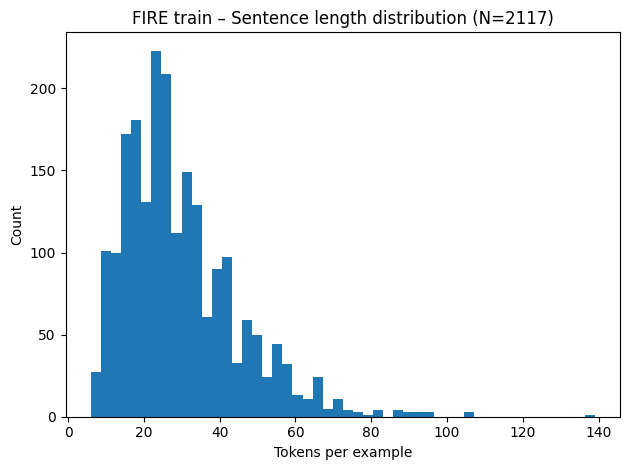

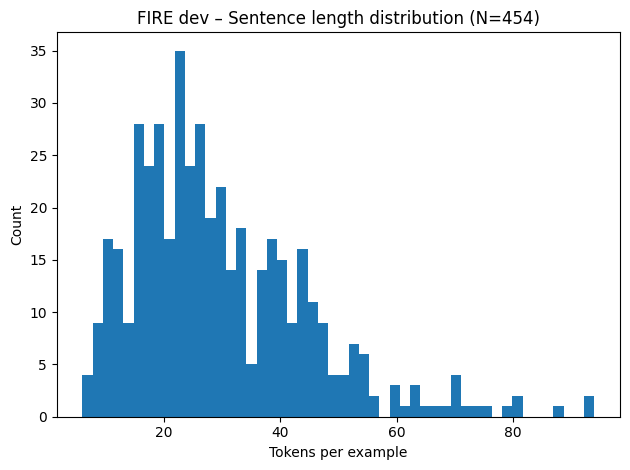

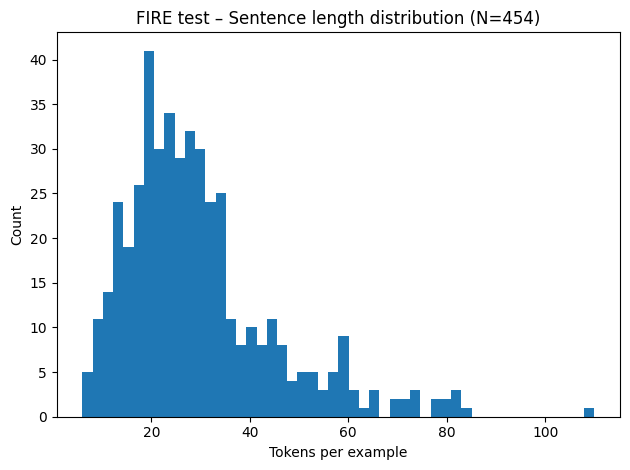

In [15]:
# 1) Sentence length histograms
plot_hist_token_lengths(fire_examples, bins=50)


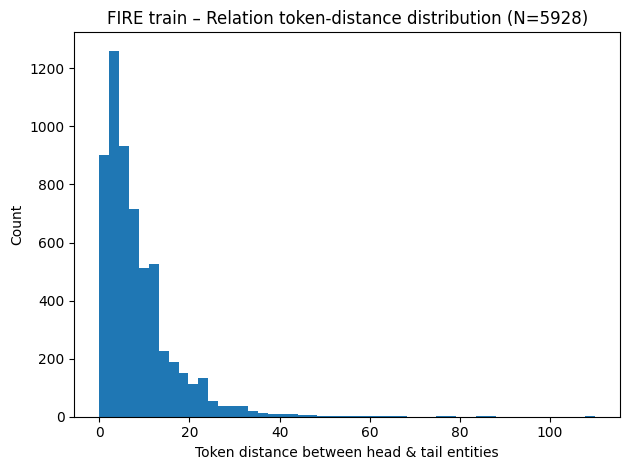

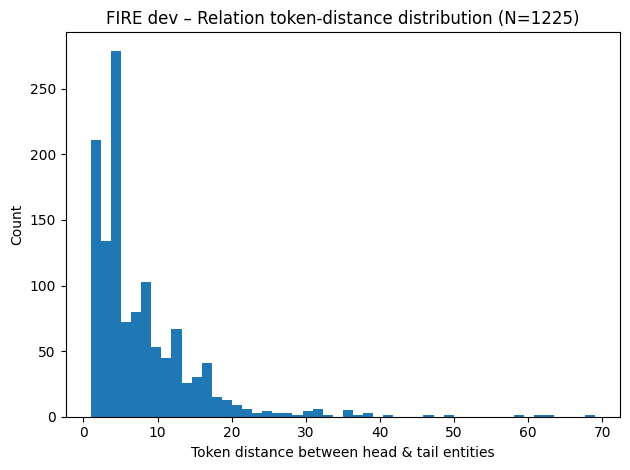

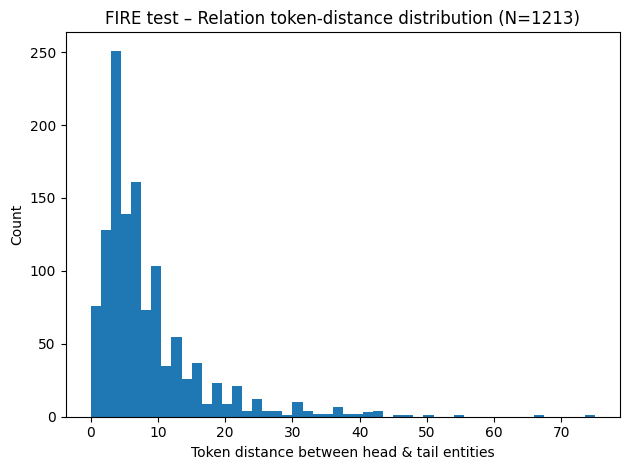

In [17]:
# 2) Relation token-distance histograms
plot_hist_rel_token_distance(fire_examples, bins=50)


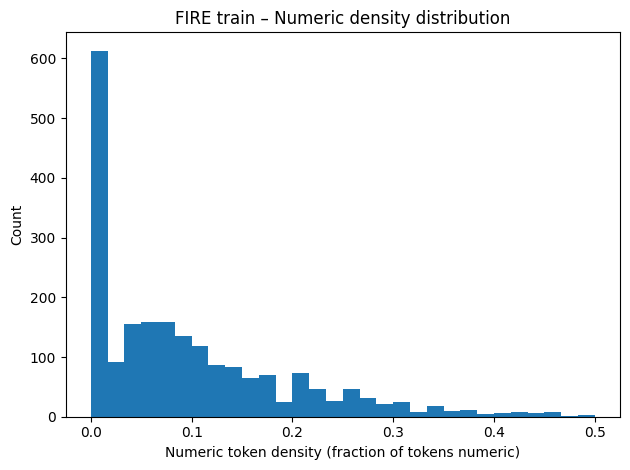

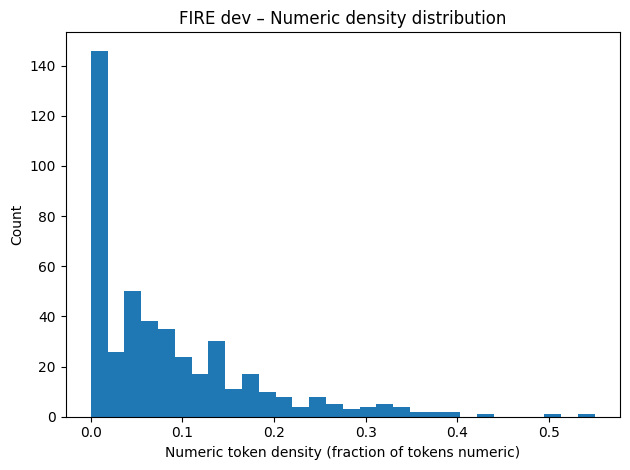

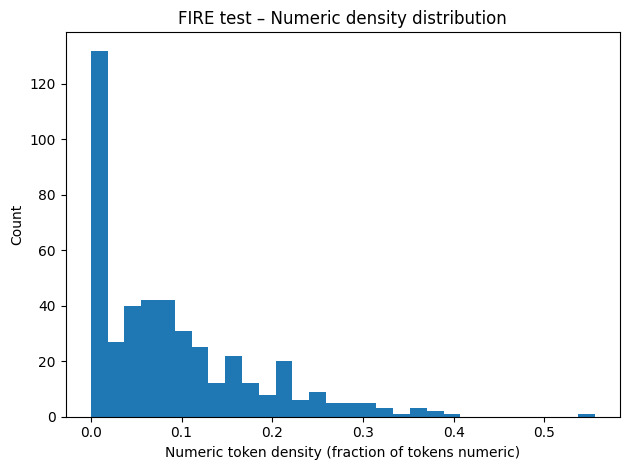

In [19]:
# 3) Numeric-token density histograms
plot_hist_numeric_density(fire_stats, bins=30)


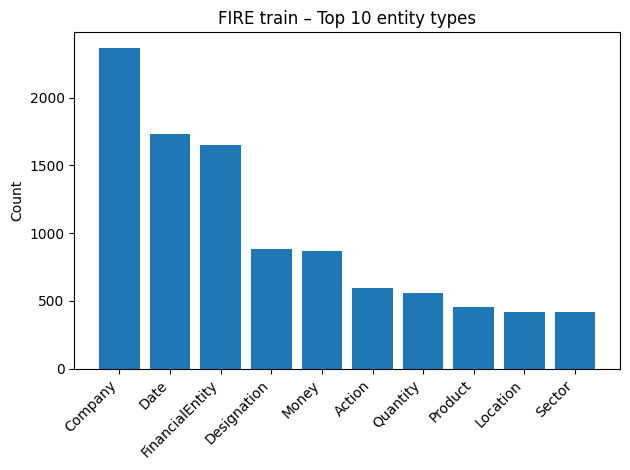

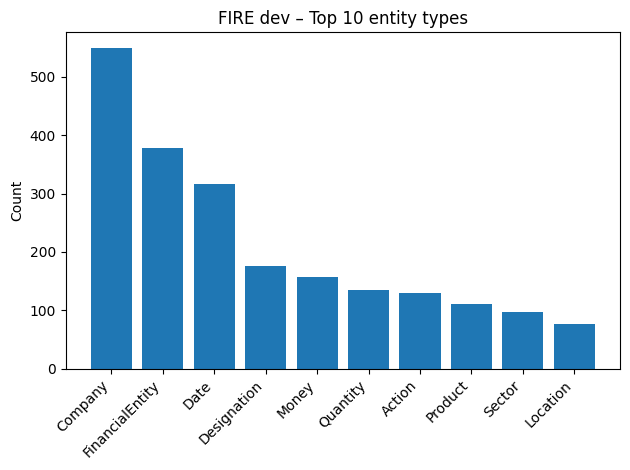

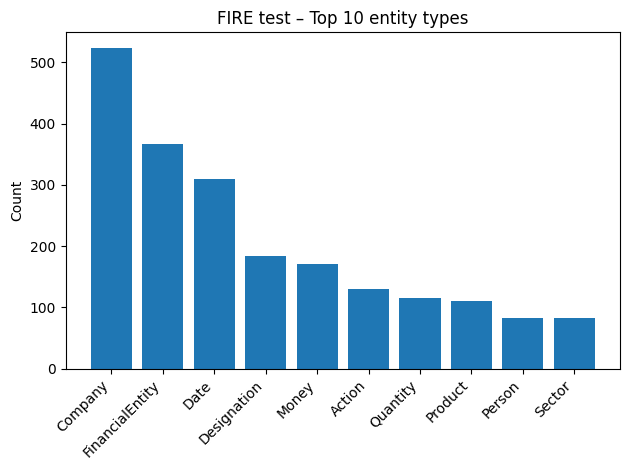

In [21]:
# 4) Top-K entity types per split
plot_bar_top_entity_types(fire_stats, top_k=10)


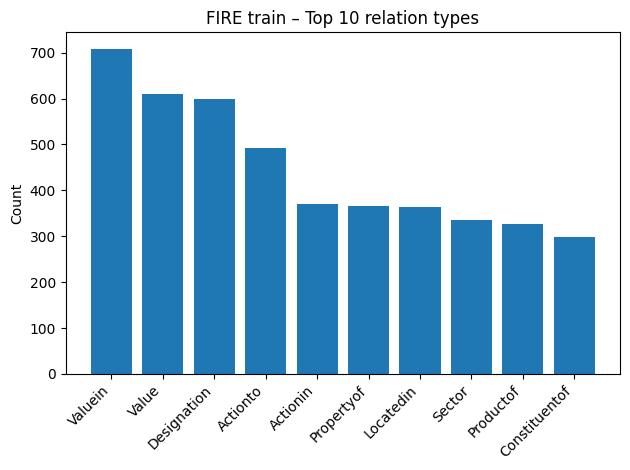

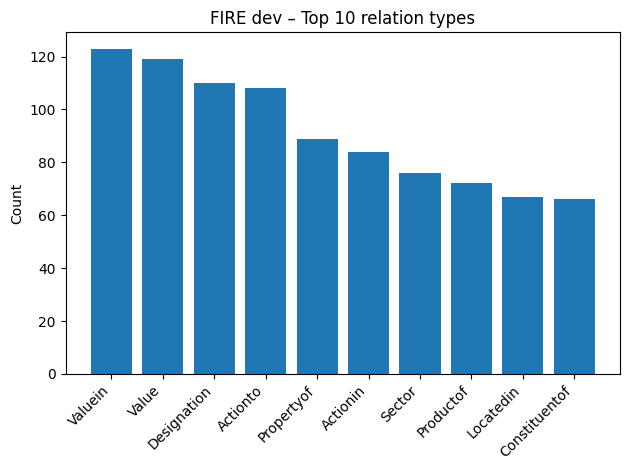

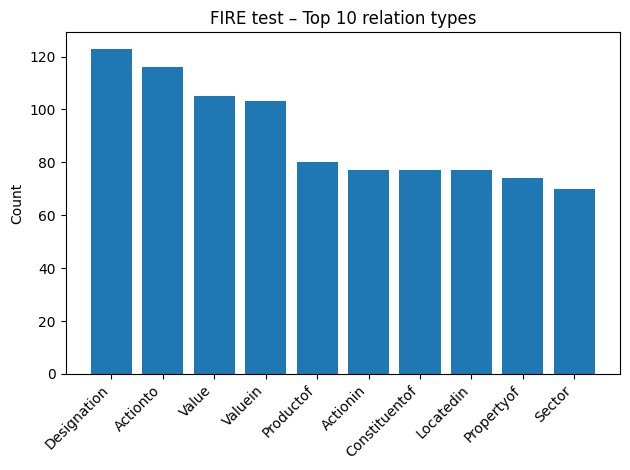

In [23]:
# 5) Top-K relation types per split
plot_bar_top_relation_types(fire_stats, top_k=10)
